In [1]:
!git clone  https://github.com/takaniwa/DSNet.git

Cloning into 'DSNet'...
remote: Enumerating objects: 702, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 702 (delta 141), reused 295 (delta 80), pack-reused 309 (from 1)
Receiving objects: 100% (702/702), 3.55 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [2]:
!pip install thop
!pip install yacs

In [3]:
import sys
sys.path.append('/kaggle/working/DSNet')

In [4]:
import os
import timeit
import random
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from models.dsnet import DSNet
from utils.criterion import OhemCrossEntropy, CrossEntropy
from utils.utils import FullModel, AverageMeter, adjust_learning_rate

In [5]:
if torch.cuda.is_available():
    print("GPU is available.")
    print("Tên GPU:", torch.cuda.get_device_name(0))
    print("Tên GPU:", torch.cuda.get_device_name(1))
else:
    print("GPU is not available.")

GPU is available.
Tên GPU: Tesla T4
Tên GPU: Tesla T4


In [6]:
color_map = np.array([
    [128, 64, 128],   # 0: Road
    [244, 35, 232],   # 1: Sidewalk
    [ 70, 70, 70],    # 2: Building
    [102, 102, 156],  # 3: Wall
    [190, 153, 153],  # 4: Fence
    [153, 153, 153],  # 5: Pole
    [250, 170, 30],   # 6: Traffic light
    [220, 220, 0],    # 7: Traffic sign
    [107, 142, 35],   # 8: Vegetation
    [152, 251, 152],  # 9: Terrain
    [70, 130, 180],   # 10: Sky
    [220, 20, 60],    # 11: Person
    [255, 0, 0],      # 12: Rider
    [0, 0, 142],      # 13: Car
    [0, 0, 70],       # 14: Truck
    [0, 60, 100],     # 15: Bus
    [0, 80, 100],     # 16: Train
    [0, 0, 230],      # 17: Motorcycle
    [119, 11, 32],    # 18: Bicycle
], dtype=np.uint8)

instance_id = [11, 12, 13, 14, 15, 16, 17, 18]

instance_color = np.array([
    [93],    # 11: Person
    [97],    # 12: Rider
    [101],    # 13: Car
    [105],    # 14: Truck
    [109],    # 15: Bus
    [121],    # 16: Train
    [125],    # 17: Motorcycle
    [128],    # 18: Bicycle
], dtype=np.uint8)

label_mapping = {-1: -1, 0: -1,
                 1: -1, 2: -1,
                 3: -1, 4: -1,
                 5: -1, 6: -1,
                 7: 0, 8: 1, 9: -1,
                 10: -1, 11: 2, 12: 3,
                 13: 4, 14: -1, 15: -1,
                 16: -1, 17: 5, 18: -1,
                 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11,
                 25: 12, 26: 13, 27: 14, 28: 15,
                 29: -1, 30: -1,
                 31: 16, 32: 17, 33: 18}

In [7]:
def get_seg_model(model_name, num_class, imgnet_pretrained):
    if 's' in model_name:
        if model_name == 'dsnet_head128':
            model = DSNet(m=2, n=2, num_classes=num_class, planes=32, name='s128', augment=True)
        if model_name == 'dsnet_head64':
            model = DSNet(m=2, n=2, num_classes=num_class, planes=32, name='s64', augment=True)
        if model_name == 'dsnet_head256':
            model = DSNet(m=2, n=2, num_classes=num_class, planes=32, name='s256', augment=True)
    if 'm' in model_name:
        model = DSNet(m=2, n=3, num_classes=num_class, planes=64, name='m',augment=True)

    if imgnet_pretrained:
        pretrained_path = '/kaggle/input/dsnet-checkpoint/best_dsnet_cityscapes_ 0.8195.pth'
        if not os.path.exists(pretrained_path):
            print(f"Error: File not found at {pretrained_path}")
        pretrained_state = torch.load(pretrained_path, map_location='cuda')
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        print('Use imagenet pre-trained weights!!!')
        print('Attention!!!')
        print(msg)
        print('Over!!!')

        if 'model.' in list(pretrained_state.keys())[0]:
            pretrained_state = {k[6:]: v for k, v in pretrained_state.items()}
        # print(pretrained_state.keys())
        model_dict = model.state_dict()

        for k, v in pretrained_state.items():
            print(f'Value Shape: {v.shape}')
            print(f'Key Shape: {model_dict[k].shape}')
            break

        pretrained_state = {k: v for k, v in pretrained_state.items() if
                            (k in model_dict and v.shape == model_dict[k].shape)}
        # print(pretrained_state.keys())
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        print('Use imagenet pre-trained weights!!!')
        print('Attention!!!')
        print(msg)
        print('Over!!!')
        model.load_state_dict(model_dict, strict=False)
    else:
        pretrained_dict = torch.load('/kaggle/working/DSNet/pretrained_models/cityscapes', map_location='cpu')
        print("11111")
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if
                           (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        print('Attention!!!')
        print(msg)
        print('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict=False)

    return model

# Train model

In [8]:
# Config train

epochs = 50
lr = 0.0003

train_image_size = [512, 1024]
batch_size = 4
shuffle = True

transform = transforms.Compose([
    transforms.Resize((train_image_size[0], train_image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345, 
                                        1.0166, 0.9969, 0.9754, 1.0489,
                                        0.8786, 1.0023, 0.9539, 0.9843, 
                                        1.1116, 0.9037, 1.0865, 1.0955, 
                                        1.0865, 1.1529, 1.0507]).cuda()

In [9]:
# config loss

MOMENTUM = 0.9
WD = 0.001

In [10]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train' , transform=None, flip_prob=0.5):
        self.root_dir = root_dir
        self.split = split
        
        self.img_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.label_dir = os.path.join(root_dir, 'gtFine', split)
        
        self.image_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.img_dir)) for f in fn if f.endswith('.png')])
        self.label_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.label_dir)) for f in fn if f.endswith('_labelIds.png')])
        
        self.transform = transform
        self.flip_prob = flip_prob
        
        if len(self.image_files) != len(self.label_files):
            print("Warning: Number of images and labels do not match!")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = self.label_files[idx]
        
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        
        # Apply flip with the given probability
        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Apply any additional transforms (e.g., resizing, normalization, etc.)
        if self.transform:
            image = self.transform(image)
        
        label = np.array(label, dtype=np.int64)
        label = np.vectorize(label_mapping.get)(label)  # Apply label mapping if needed
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [11]:
def get_sampler(dataset):
    from utils.distributed import is_distributed
    if is_distributed():
        from torch.utils.data.distributed import DistributedSampler
        return DistributedSampler(dataset)
    else:
        return None

In [12]:
dataset_path = '/kaggle/input/dsnet-dataset/DSNet'
subset_indices = list(range(250))

train_set = CityscapesDataset(root_dir=dataset_path, split='train', transform=transform, flip_prob=0.4)
train_subset = Subset(train_set, subset_indices)
train_sampler = get_sampler(train_subset)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True, drop_last=True, sampler = train_sampler)

In [13]:
model = get_seg_model('m', 19, True)

/tmp/ipykernel_30/3269376050.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(pretrained_path, map_location='cuda')


Use imagenet pre-trained weights!!!
Attention!!!
Loaded 693 parameters!
Over!!!
Value Shape: torch.Size([64, 3, 3, 3])
Key Shape: torch.Size([64, 3, 3, 3])
Use imagenet pre-trained weights!!!
Attention!!!
Loaded 691 parameters!
Over!!!


In [14]:
model = nn.DataParallel(model)

In [15]:
params_dict = dict(model.named_parameters())
params = [{'params': list(params_dict.values()), 'lr': lr}]

criterion = OhemCrossEntropy(weight=class_weights)

optimizer = torch.optim.SGD(params,
                        lr=lr,
                        momentum=MOMENTUM,
                        weight_decay=WD,
                        nesterov=False,
                        )

In [16]:
def save_model(model, file_path):
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Lưu mô hình
    torch.save(model.state_dict(), file_path)
    print(f"Mô hình đã được lưu tại {file_path}")

In [17]:
def calculate_PA(output, target):
    """Tính Pixel Accuracy (PA)."""
    # Dự đoán lớp có xác suất cao nhất tại mỗi pixel
    predicted = torch.argmax(output, dim=1)
    
    # Tạo mặt nạ cho các pixel hợp lệ (target != -1)
    valid_pixels = (target != -1)

    # Đếm số pixel dự đoán đúng trên các pixel hợp lệ
    correct = torch.sum((target == predicted) & valid_pixels)
    total = torch.sum(valid_pixels)  # Tổng số pixel hợp lệ

    # Tính Pixel Accuracy
    if total > 0:
        return correct.float() / total.float()  # Chuyển sang kiểu float để tránh chia lấy nguyên
    else:
        return 0.0

def calculate_iou(output, target, num_classes):
    with torch.no_grad():
        # Lấy nhãn dự đoán bằng cách lấy argmax theo chiều classes
        predicted = torch.argmax(output, dim=1)  # [batch_size, height, width]

        # Tạo tensor để lưu trữ tổng IoU cho từng lớp
        ious = []

        # Lấy các lớp xuất hiện trong predicted và target
        classes_in_true = torch.unique(target)
        classes_in_pred = torch.unique(predicted)

        # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
        classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

        # Tính IoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
        for cls in classes_in_true_no_neg1:
            cls = cls.item()  # Chuyển sang kiểu int để sử dụng như chỉ mục

            # Mask cho từng lớp
            pred_mask = (predicted == cls)
            true_mask = (target == cls)

            # Tính Intersection và Union
            intersection = torch.sum(pred_mask & true_mask).item()
            union = torch.sum(pred_mask | true_mask).item()

            if union == 0:
                ious.append(float('nan'))  # Nếu không có pixel nào thuộc lớp đó
            else:
                ious.append(intersection / union)

        # Tính IoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` mà không có trong `y_true`
        neg1_pixels = (target == -1)
        if torch.sum(neg1_pixels) > 0:
            pred_classes_not_in_true = torch.tensor(
                [cls for cls in classes_in_pred if cls not in classes_in_true_no_neg1],
                device=target.device
            )

            # Tính IoU cho các pixel lớp -1
            pred_mask_neg1 = torch.isin(predicted, pred_classes_not_in_true)  # Chỉ có trên PyTorch 1.10+
            intersection_neg1 = torch.sum(neg1_pixels & pred_mask_neg1).item()
            union_neg1 = torch.sum(neg1_pixels | pred_mask_neg1).item()

            if union_neg1 == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection_neg1 / union_neg1)

    # Tính mIoU bằng cách lấy trung bình các IoU, bỏ qua giá trị NaN
    return np.nanmean(ious)

In [18]:
def train(model, train_loader, criterion, optimizer, num_epochs, device, save_path, alpha=1, beta=2):

    best_loss, best_iou = float('inf'), float('inf')
    losses = []
    losses_crossr_entropy = []
    losses_iou = []
    pixel_acc = []
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []
        epoch_ohem_loss = 0.0
        epoch_iou_loss = []
        epoch_pa = 0.0
        total_batch = len(train_loader)

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            output_resized = [F.interpolate(outputs[i], size=(1024, 2048), mode='bilinear', align_corners=False) for i in range(3)]
            
            loss1 = criterion(output_resized[0], labels)
            loss2 = criterion(output_resized[1], labels)
            loss3 = criterion(output_resized[2], labels)
            
            ohem_loss = (loss1 + loss2 + loss3) / 3
            epoch_ohem_loss += ohem_loss
            
            iou_loss = 1 -  calculate_iou(output_resized[2], labels, 19)
            epoch_iou_loss.append(iou_loss)
            
            epoch_pa += calculate_PA(output_resized[0], labels)
            
            total_loss = alpha * ohem_loss + beta * iou_loss
            
            total_loss.backward()
            optimizer.step()
            
            epoch_loss.append(total_loss.item())
        
        # Lưu thông tin epoch
        losses.append(np.mean(epoch_loss))
        losses_crossr_entropy.append(epoch_ohem_loss / total_batch)
        pixel_acc.append(epoch_pa / total_batch)
        losses_iou.append(np.mean(epoch_iou_loss))
        
        print(f"Loss: {losses[-1]:.4f}, Ohem Loss: {losses_crossr_entropy[-1]:.4f}, IoU Loss: {losses_iou[-1]:.4f}")
        
        # Lưu mô hình nếu loss giảm
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            save_model(model, save_path)
            print(f"Model saved at epoch {epoch+1} with Loss: {best_loss:.4f}, Ohem Loss: {losses_crossr_entropy[-1]:.4f}, IoU Loss: {losses_iou[-1]:.4f}")
    
    return losses, losses_crossr_entropy, losses_iou, pixel_acc

In [19]:
total_losses, ohem_losses, iou_losses, pixel_acc = train(model, train_loader, criterion, optimizer, epochs, 'cuda', "/kaggle/working/model.pth")

Epoch 1/50:   0%|          | 0/62 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Epoch 1/50: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Loss: 1.4530, Ohem Loss: 0.6315, IoU Loss: 0.4107
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 1 with Loss: 1.4530, Ohem Loss: 0.6315, IoU Loss: 0.4107


Epoch 2/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.3279, Ohem Loss: 0.5767, IoU Loss: 0.3756
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 2 with Loss: 1.3279, Ohem Loss: 0.5767, IoU Loss: 0.3756


Epoch 3/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.2842, Ohem Loss: 0.5571, IoU Loss: 0.3636
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 3 with Loss: 1.2842, Ohem Loss: 0.5571, IoU Loss: 0.3636


Epoch 4/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.2594, Ohem Loss: 0.5498, IoU Loss: 0.3548
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 4 with Loss: 1.2594, Ohem Loss: 0.5498, IoU Loss: 0.3548


Epoch 5/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.2372, Ohem Loss: 0.5428, IoU Loss: 0.3472
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 5 with Loss: 1.2372, Ohem Loss: 0.5428, IoU Loss: 0.3472


Epoch 6/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.2389, Ohem Loss: 0.5401, IoU Loss: 0.3494


Epoch 7/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.2101, Ohem Loss: 0.5337, IoU Loss: 0.3382
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 7 with Loss: 1.2101, Ohem Loss: 0.5337, IoU Loss: 0.3382


Epoch 8/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.2095, Ohem Loss: 0.5282, IoU Loss: 0.3407
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 8 with Loss: 1.2095, Ohem Loss: 0.5282, IoU Loss: 0.3407


Epoch 9/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.1840, Ohem Loss: 0.5236, IoU Loss: 0.3302
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 9 with Loss: 1.1840, Ohem Loss: 0.5236, IoU Loss: 0.3302


Epoch 10/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.1760, Ohem Loss: 0.5246, IoU Loss: 0.3257
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 10 with Loss: 1.1760, Ohem Loss: 0.5246, IoU Loss: 0.3257


Epoch 11/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.1847, Ohem Loss: 0.5215, IoU Loss: 0.3316


Epoch 12/50: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Loss: 1.1833, Ohem Loss: 0.5223, IoU Loss: 0.3305


Epoch 13/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1704, Ohem Loss: 0.5180, IoU Loss: 0.3262
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 13 with Loss: 1.1704, Ohem Loss: 0.5180, IoU Loss: 0.3262


Epoch 14/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1789, Ohem Loss: 0.5211, IoU Loss: 0.3289


Epoch 15/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1478, Ohem Loss: 0.5126, IoU Loss: 0.3176
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 15 with Loss: 1.1478, Ohem Loss: 0.5126, IoU Loss: 0.3176


Epoch 16/50: 100%|██████████| 62/62 [01:45<00:00,  1.69s/it]


Loss: 1.1540, Ohem Loss: 0.5157, IoU Loss: 0.3192


Epoch 17/50: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]


Loss: 1.1501, Ohem Loss: 0.5095, IoU Loss: 0.3203


Epoch 18/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1446, Ohem Loss: 0.5078, IoU Loss: 0.3184
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 18 with Loss: 1.1446, Ohem Loss: 0.5078, IoU Loss: 0.3184


Epoch 19/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1487, Ohem Loss: 0.5064, IoU Loss: 0.3212


Epoch 20/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1450, Ohem Loss: 0.5045, IoU Loss: 0.3203


Epoch 21/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.1269, Ohem Loss: 0.5042, IoU Loss: 0.3114
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 21 with Loss: 1.1269, Ohem Loss: 0.5042, IoU Loss: 0.3114


Epoch 22/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1304, Ohem Loss: 0.5050, IoU Loss: 0.3127


Epoch 23/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.1208, Ohem Loss: 0.5052, IoU Loss: 0.3078
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 23 with Loss: 1.1208, Ohem Loss: 0.5052, IoU Loss: 0.3078


Epoch 24/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1187, Ohem Loss: 0.4975, IoU Loss: 0.3106
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 24 with Loss: 1.1187, Ohem Loss: 0.4975, IoU Loss: 0.3106


Epoch 25/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1199, Ohem Loss: 0.5033, IoU Loss: 0.3083


Epoch 26/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1232, Ohem Loss: 0.4977, IoU Loss: 0.3127


Epoch 27/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.1061, Ohem Loss: 0.4974, IoU Loss: 0.3043
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 27 with Loss: 1.1061, Ohem Loss: 0.4974, IoU Loss: 0.3043


Epoch 28/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1198, Ohem Loss: 0.5019, IoU Loss: 0.3089


Epoch 29/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1008, Ohem Loss: 0.4977, IoU Loss: 0.3015
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 29 with Loss: 1.1008, Ohem Loss: 0.4977, IoU Loss: 0.3015


Epoch 30/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.1107, Ohem Loss: 0.4996, IoU Loss: 0.3055


Epoch 31/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.0957, Ohem Loss: 0.4956, IoU Loss: 0.3001
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 31 with Loss: 1.0957, Ohem Loss: 0.4956, IoU Loss: 0.3001


Epoch 32/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.1037, Ohem Loss: 0.4935, IoU Loss: 0.3051


Epoch 33/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.0952, Ohem Loss: 0.4952, IoU Loss: 0.3000
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 33 with Loss: 1.0952, Ohem Loss: 0.4952, IoU Loss: 0.3000


Epoch 34/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.0923, Ohem Loss: 0.4901, IoU Loss: 0.3011
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 34 with Loss: 1.0923, Ohem Loss: 0.4901, IoU Loss: 0.3011


Epoch 35/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.0870, Ohem Loss: 0.4880, IoU Loss: 0.2995
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 35 with Loss: 1.0870, Ohem Loss: 0.4880, IoU Loss: 0.2995


Epoch 36/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1034, Ohem Loss: 0.4907, IoU Loss: 0.3064


Epoch 37/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.0870, Ohem Loss: 0.4871, IoU Loss: 0.2999
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 37 with Loss: 1.0870, Ohem Loss: 0.4871, IoU Loss: 0.2999


Epoch 38/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.1110, Ohem Loss: 0.4966, IoU Loss: 0.3072


Epoch 39/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.0833, Ohem Loss: 0.4950, IoU Loss: 0.2942
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 39 with Loss: 1.0833, Ohem Loss: 0.4950, IoU Loss: 0.2942


Epoch 40/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.0770, Ohem Loss: 0.4931, IoU Loss: 0.2919
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 40 with Loss: 1.0770, Ohem Loss: 0.4931, IoU Loss: 0.2919


Epoch 41/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.0873, Ohem Loss: 0.4873, IoU Loss: 0.3000


Epoch 42/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Loss: 1.0759, Ohem Loss: 0.4878, IoU Loss: 0.2941
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 42 with Loss: 1.0759, Ohem Loss: 0.4878, IoU Loss: 0.2941


Epoch 43/50: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Loss: 1.0794, Ohem Loss: 0.4870, IoU Loss: 0.2962


Epoch 44/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.0826, Ohem Loss: 0.4868, IoU Loss: 0.2979


Epoch 45/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.0686, Ohem Loss: 0.4827, IoU Loss: 0.2929
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 45 with Loss: 1.0686, Ohem Loss: 0.4827, IoU Loss: 0.2929


Epoch 46/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.0822, Ohem Loss: 0.4866, IoU Loss: 0.2978


Epoch 47/50: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


Loss: 1.0552, Ohem Loss: 0.4776, IoU Loss: 0.2888
Mô hình đã được lưu tại /kaggle/working/model.pth
Model saved at epoch 47 with Loss: 1.0552, Ohem Loss: 0.4776, IoU Loss: 0.2888


Epoch 48/50: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]


Loss: 1.0607, Ohem Loss: 0.4857, IoU Loss: 0.2875


Epoch 49/50: 100%|██████████| 62/62 [01:45<00:00,  1.69s/it]


Loss: 1.0761, Ohem Loss: 0.4854, IoU Loss: 0.2953


Epoch 50/50: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

Loss: 1.0570, Ohem Loss: 0.4775, IoU Loss: 0.2897


Total loss: 1.0570, Ohem loss: 0.4775, IoU loss: 0.2897, Pixel Accuracy: 0.9785


Text(0.5, 1.0, 'Pixel Accuracy')

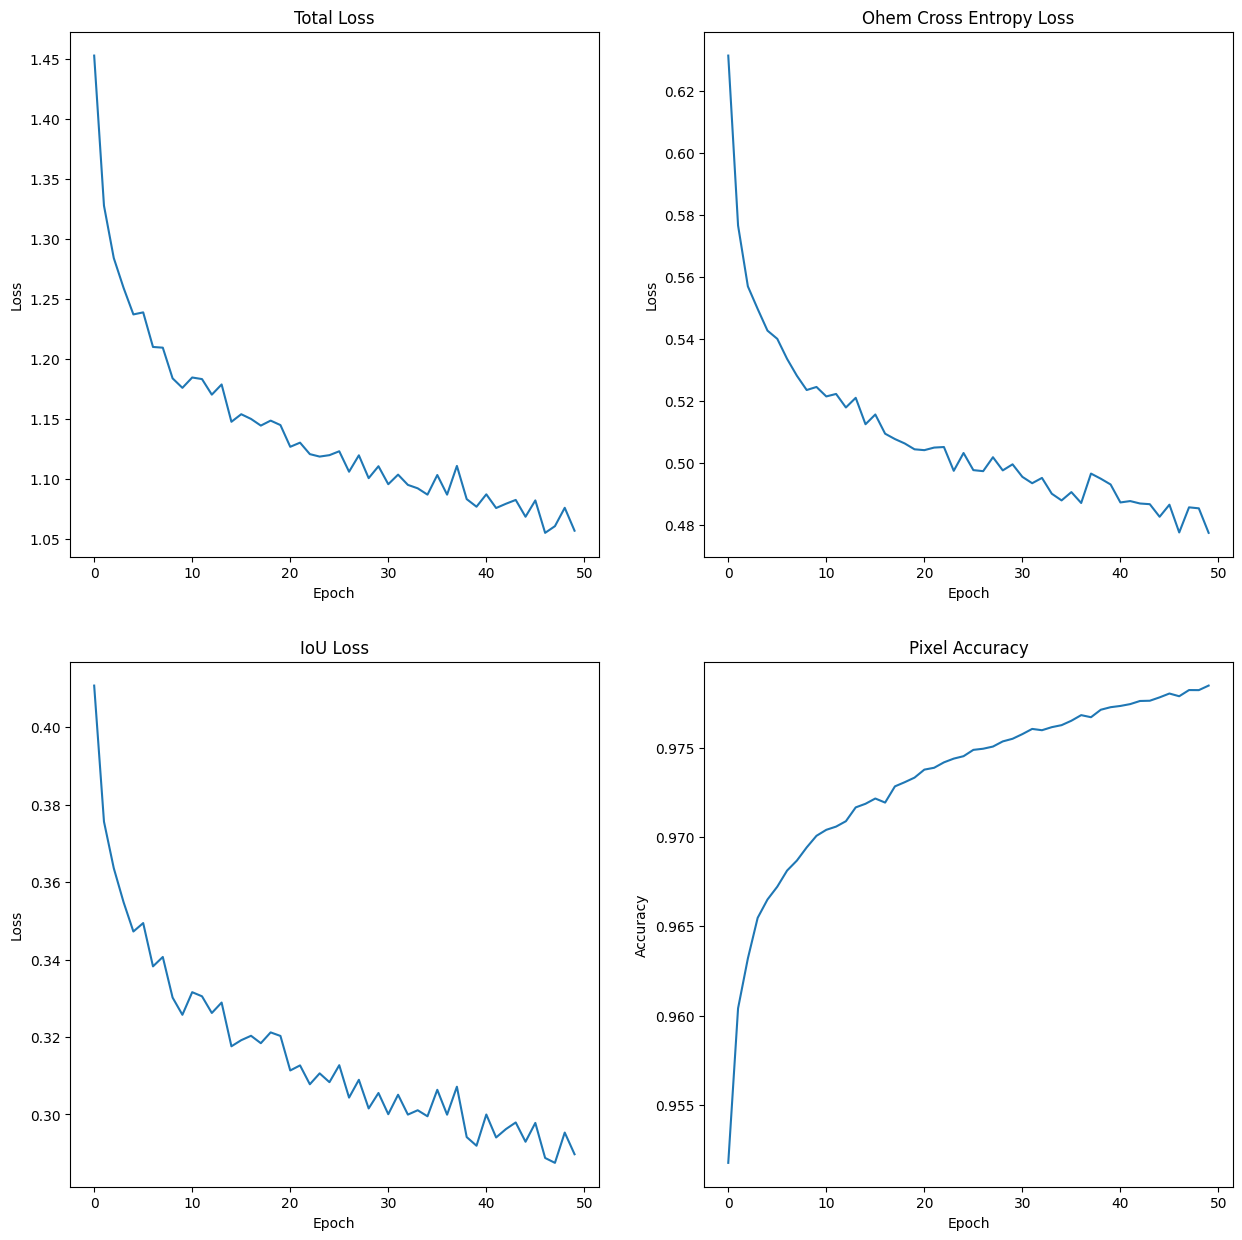

In [23]:
plt.figure(figsize=(15, 15))

print(f'Total loss: {total_losses[-1]:.4f}, Ohem loss: {ohem_losses[-1]:.4f}, IoU loss: {iou_losses[-1]:.4f}, Pixel Accuracy: {pixel_acc[-1]:.4f}')

plt.subplot(2, 2, 1)
plt.plot(total_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Total Loss")

plt.subplot(2, 2, 2)
ohem_losses_tensor = torch.tensor(ohem_losses)
ohem_losses_tensor = ohem_losses_tensor.to('cuda')
ohem_losses = ohem_losses_tensor.cpu().numpy()
plt.plot(ohem_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Ohem Cross Entropy Loss")

plt.subplot(2, 2, 3)
plt.plot(iou_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("IoU Loss")

plt.subplot(2, 2, 4)
pixel_acc_tensor = torch.tensor(pixel_acc)
pixel_acc_tensor = pixel_acc_tensor.to('cuda')
pixel_acc = pixel_acc_tensor.cpu().numpy()
plt.plot(pixel_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Pixel Accuracy")

# Test model DSNet

In [24]:
def get_confusion_matrix(label, pred, size, num_class=19, ignore=-1):
    output = pred.cpu().numpy().transpose(0, 2, 3, 1)
    seg_pred = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
    seg_gt = np.asarray(
    label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=np.int64)

    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]

    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((num_class, num_class))

    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                confusion_matrix[i_label,
                                 i_pred] = label_count[cur_index]
    return confusion_matrix

In [25]:
def validate(model, testloader, criterion, num_classes):
    model.eval()
    model.to('cuda')
    ave_loss = AverageMeter()
    pixel_acc = 0
    confusion_matrix = np.zeros((num_classes, num_classes))
    mean_loss = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(testloader):
            images, labels = batch
            size = labels.size()
            
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = model(images)
            
            if not isinstance(outputs, (list, tuple)):
                outputs = [outputs] 
                
            confusion_matrix += get_confusion_matrix(
                labels,
                outputs[1],
                size
            )
            
            loss = criterion(outputs[0], labels)
            ave_loss.update(loss)
            
    pos = confusion_matrix.sum(1)
    res = confusion_matrix.sum(0)
    tp = np.diag(confusion_matrix)
    pixel_acc = tp.sum()/pos.sum()
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    return ave_loss.average(), mean_IoU, pixel_acc

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = CityscapesDataset(root_dir=dataset_path, split='val', transform=transform)
test_sampler = get_sampler(test_set)
test_loader = DataLoader(test_set, batch_size=1, shuffle=shuffle, num_workers=2, pin_memory=True, drop_last=True, sampler = test_sampler)

## trước fine_tune

In [27]:
ave_loss, mean_IoU, pixel_acc = validate(model, test_loader, criterion, 19)

In [28]:
print(f'Average loss: {ave_loss:.4f}')
print(f'Mean Pixel Accuracy: {pixel_acc:.4f}')
print(f'Mean Intersection over Union: {mean_IoU:.4f}')

Average loss: 0.6923
Mean Pixel Accuracy: 0.9617
Mean Intersection over Union: 0.7918


## Sau fine_tune

In [30]:
ave_loss, mean_IoU, pixel_acc = validate(model, test_loader, criterion, 19)

In [31]:
print(f'Average loss: {ave_loss:.4f}')
print(f'Mean Pixel Accuracy: {pixel_acc:.4f}')
print(f'Mean Intersection over Union: {mean_IoU:.4f}')

Average loss: 0.9565
Mean Pixel Accuracy: 0.9668
Mean Intersection over Union: 0.8192


# Visualization Output of model

In [21]:
def cal_pixel_accuracy(y_true, y_pred):
    """Tính Pixel Accuracy (PA)."""
    valid_pixels = (y_true != -1)

    # Đếm số pixel dự đoán đúng trên các pixel hợp lệ
    correct = np.sum((y_true == y_pred) & valid_pixels)
    total = np.sum(valid_pixels)  # Tổng số pixel hợp lệ

    # Tính Pixel Accuracy
    if total > 0:
        return correct / total
    else:
        return 0

def cal_mean_pixel_accuracy(y_true, y_pred, num_classes):
    """Tính Mean Pixel Accuracy (mPA)."""
    mpa = 0
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính mPA cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for c in classes_in_true_no_neg1:
        true_class_pixels = (y_true == c)
        pred_class_pixels = (y_pred == c)

        # Tính chính xác cho lớp c
        correct_class_pixels = np.sum(true_class_pixels & pred_class_pixels)
        total_class_pixels = np.sum(true_class_pixels)

        if total_class_pixels > 0:
            class_accuracy = correct_class_pixels / total_class_pixels
            mpa += class_accuracy

    # Tính mPA cho lớp -1 trong `y_true` với các lớp trong `y_pred`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Tìm các lớp có trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính độ chính xác cho lớp -1
        correct_neg1_pixels = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        total_neg1_pixels = np.sum(neg1_pixels)

        # Nếu có pixel thuộc lớp -1
        if total_neg1_pixels > 0:
            neg1_accuracy = correct_neg1_pixels / total_neg1_pixels
            mpa += neg1_accuracy

    # Chia mPA cho tổng số lượng lớp thực tế để lấy trung bình
    mpa = mpa / (len(classes_in_true_no_neg1) + 1)  # +1 để tính lớp -1 riêng
    return mpa

def cal_iou(y_true, y_pred, num_classes):
    """Tính Mean Intersection over Union (mIoU)"""
    ious = []
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính IoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for i in classes_in_true_no_neg1:
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))

        if union == 0:
            ious.append(np.nan)  # Nếu không có pixel nào thuộc lớp đó trong cả y_true và y_pred
        else:
            ious.append(intersection / union)

    # Tính IoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` mà không có trong `y_true`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Lấy các lớp trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính IoU cho các pixel lớp -1
        intersection_neg1 = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        union_neg1 = np.sum(neg1_pixels | np.isin(y_pred, pred_classes_not_in_true))

        if union_neg1 == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection_neg1 / union_neg1)

    # Tính mIoU bằng cách lấy trung bình các IoU, bỏ qua giá trị NaN
    return np.nanmean(ious)

def cal_frequency_weighted_iou(y_true, y_pred, num_classes):
    """Tính Frequency Weighted IoU (FWIoU)."""
    total_pixels = y_true.size
    fwiou = 0
    classes_in_true = np.unique(y_true)
    classes_in_pred = np.unique(y_pred)

    # Loại bỏ lớp -1 khỏi danh sách các lớp cần duyệt trong ground truth
    classes_in_true_no_neg1 = classes_in_true[classes_in_true != -1]

    # Tính FWIoU cho các lớp có trong ground truth (ngoại trừ lớp -1)
    for i in classes_in_true_no_neg1:
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        freq = np.sum(y_true == i) / total_pixels

        if union > 0:
            fwiou += freq * (intersection / union)

    # Tính FWIoU cho lớp -1 trong `y_true` với các lớp trong `y_pred` không có trong `y_true`
    neg1_pixels = (y_true == -1)
    if np.sum(neg1_pixels) > 0:
        # Lấy các lớp trong `y_pred` nhưng không có trong `y_true` (ngoại trừ -1)
        pred_classes_not_in_true = np.setdiff1d(classes_in_pred, classes_in_true_no_neg1)

        # Tính intersection và union cho lớp -1
        intersection_neg1 = np.sum(neg1_pixels & np.isin(y_pred, pred_classes_not_in_true))
        union_neg1 = np.sum(neg1_pixels | np.isin(y_pred, pred_classes_not_in_true))
        freq_neg1 = np.sum(neg1_pixels) / total_pixels

        if union_neg1 > 0:
            fwiou += freq_neg1 * (intersection_neg1 / union_neg1)

    return fwiou

def evaluate(y_true, y_pred, num_classes):
    print(f'Pixel Accuracy: {cal_pixel_accuracy(y_true, y_pred)}')
    print(f'Mean Pixel Accuracy: {cal_mean_pixel_accuracy(y_true, y_pred, num_classes)}')
    print(f'Intersection over Union: {cal_iou(y_true, y_pred, num_classes)}')
    print(f'Frequency Weighted IoU: {cal_frequency_weighted_iou(y_true, y_pred, num_classes)}')

## Model sử dụng checkpoint sau khi fine-tune

In [7]:
model_checkpoint = DSNet(m=2, n=3, num_classes=19, planes=64, name='m',augment=True)

pretrained_path = '/kaggle/input/dsnet-checkpoint/model.pth'
if not os.path.exists(pretrained_path):
    print(f"Error: File not found at {pretrained_path}")
pretrained_state = torch.load(pretrained_path, map_location='cuda')
msg = 'Loaded {} parameters!'.format(len(pretrained_state))
print('Use imagenet pre-trained weights!!!')
print('Attention!!!')
print(msg)
print('Over!!!')

if 'module.' in list(pretrained_state.keys())[0]:
    pretrained_state = {k[7:]: v for k, v in pretrained_state.items()}
# print(pretrained_state.keys())
model_dict = model_checkpoint.state_dict()

for k, v in pretrained_state.items():
    print(f'Value Shape: {v.shape}')
    print(f'Key Shape: {model_dict[k].shape}')
    break

pretrained_state = {k: v for k, v in pretrained_state.items() if
                    (k in model_dict and v.shape == model_dict[k].shape)}
# print(pretrained_state.keys())
model_dict.update(pretrained_state)
msg = 'Loaded {} parameters!'.format(len(pretrained_state))
print('Use imagenet pre-trained weights!!!')
print('Attention!!!')
print(msg)
print('Over!!!')
model_checkpoint.load_state_dict(model_dict, strict=False)

/tmp/ipykernel_30/3902223513.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(pretrained_path, map_location='cuda')


Use imagenet pre-trained weights!!!
Attention!!!
Loaded 691 parameters!
Over!!!
Value Shape: torch.Size([64, 3, 3, 3])
Key Shape: torch.Size([64, 3, 3, 3])
Use imagenet pre-trained weights!!!
Attention!!!
Loaded 691 parameters!
Over!!!


<All keys matched successfully>

In [8]:
device = torch.device('cuda')

model_checkpoint.eval()

model_checkpoint.to(device)

DSNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

(2048, 1024)


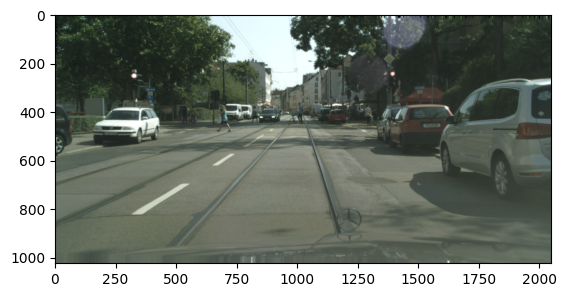

In [9]:
img_path = '/kaggle/input/dsnet-dataset/DSNet/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png'

img = cv2.imread(img_path)

image = Image.open(img_path).convert('RGB')
original_size = image.size

print(original_size)
plt.imshow(image)

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
input = transform(image).unsqueeze(0).to(device)
print(input.shape)

torch.Size([1, 3, 1024, 2048])


In [12]:
output = model_checkpoint(input)
print(f'Len of Output: {len(output)}')
print(output[0].shape)

Len of Output: 3
torch.Size([1, 19, 1024, 2048])


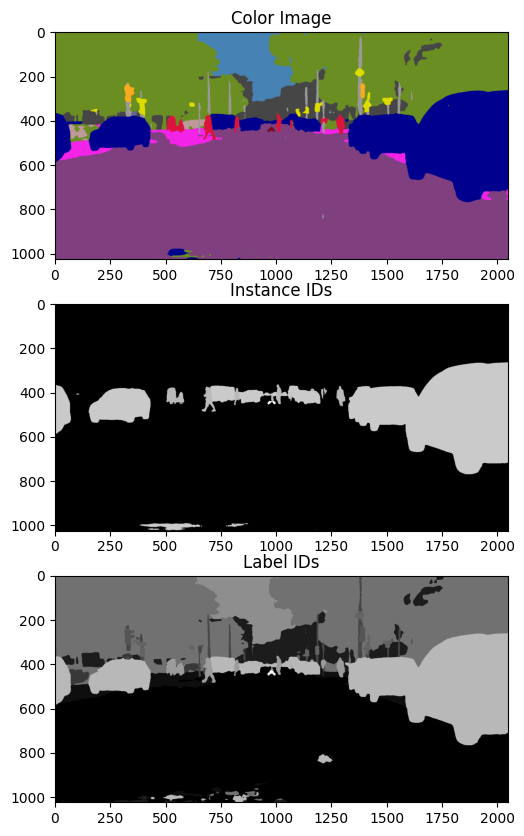

In [13]:
plt.figure(figsize=(10, 10))
original_size_image = (original_size[1], original_size[0])

for i in range(3):
    channels_tensor = output[i][0]
    output_predictions = channels_tensor.argmax(0)
    output_np = output_predictions.cpu().numpy()

    output_resized = cv2.resize(output_np, (original_size_image[1], original_size_image[0]), interpolation=cv2.INTER_NEAREST)

    plt.subplot(3, 1, i + 1)

    if i == 0:
        height, width = output_resized.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in range(color_map.shape[0]):
            rgb_image[output_resized == class_id] = color_map[class_id]
        plt.imshow(rgb_image)
        plt.title('Color Image')
    elif i == 1:
        height, width = output_resized.shape
        instance_image = np.zeros((height, width), dtype=np.uint8)
        for class_id in range(19):
            if class_id in instance_id:
                instance_image[output_resized == class_id] = instance_color[class_id - 11]
            else:
                instance_image[output_resized == class_id] = 0
        plt.imshow(instance_image, cmap='gray')
        plt.title('Instance IDs')
    else:
        plt.imshow(output_resized, cmap='gray')
        plt.title('Label IDs')

In [14]:
img_true_path = '/kaggle/input/dsnet-dataset/DSNet/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png'

img_true = cv2.imread(img_true_path)
img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)

img_true = np.vectorize(label_mapping.get)(img_true)

Text(0.5, 1.0, 'Prediction Image')

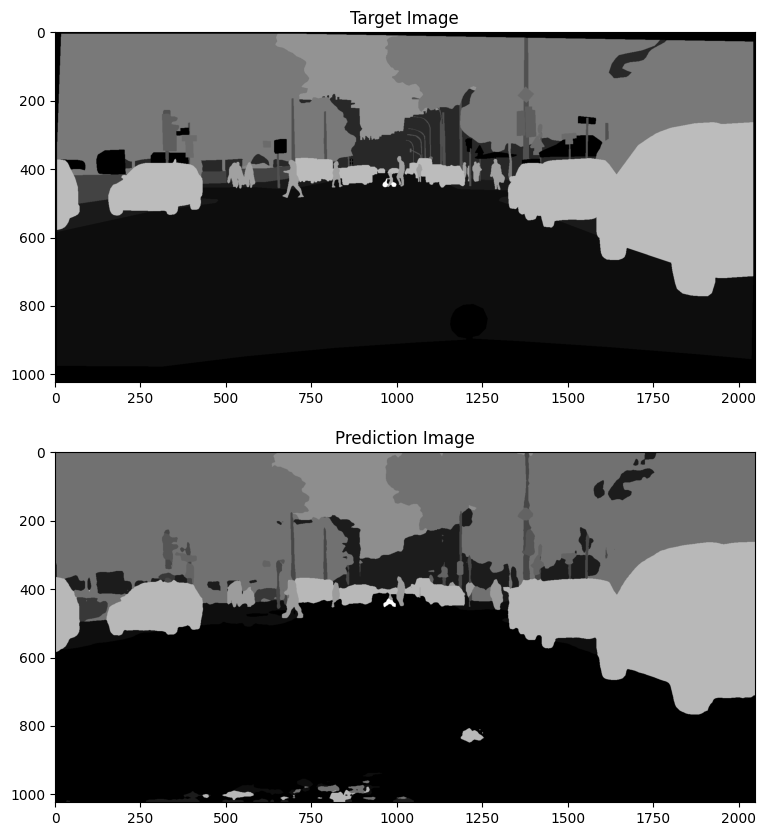

In [15]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")

plt.subplot(2, 1, 2)
plt.imshow(output_resized, cmap='gray')
plt.title("Prediction Image")

In [22]:
evaluate(img_true, output_resized, 19)

Pixel Accuracy: 0.9635401409857742
Mean Pixel Accuracy: 0.6375109447494913
Intersection over Union: 0.512220568444811
Frequency Weighted IoU: 0.7320923890765868


## Model sử dụng checkpoint trước khi fine-tune

In [24]:
model_checkpoint = DSNet(m=2, n=3, num_classes=19, planes=64, name='m',augment=True)

pretrained_path = '/kaggle/input/dsnet-checkpoint/best_dsnet_cityscapes_ 0.8195.pth'
if not os.path.exists(pretrained_path):
    print(f"Error: File not found at {pretrained_path}")
pretrained_state = torch.load(pretrained_path, map_location='cpu')
msg = 'Loaded {} parameters!'.format(len(pretrained_state))
print('Use imagenet pre-trained weights!!!')
print('Attention!!!')
print(msg)
print('Over!!!')

if 'model.' in list(pretrained_state.keys())[0]:
    pretrained_state = {k[6:]: v for k, v in pretrained_state.items()}
# print(pretrained_state.keys())
model_dict = model_checkpoint.state_dict()

for k, v in pretrained_state.items():
    print(f'Value Shape: {v.shape}')
    print(f'Key Shape: {model_dict[k].shape}')
    break

pretrained_state = {k: v for k, v in pretrained_state.items() if
                    (k in model_dict and v.shape == model_dict[k].shape)}
# print(pretrained_state.keys())
model_dict.update(pretrained_state)
msg = 'Loaded {} parameters!'.format(len(pretrained_state))
print('Use imagenet pre-trained weights!!!')
print('Attention!!!')
print(msg)
print('Over!!!')
model_checkpoint.load_state_dict(model_dict, strict=False)

/tmp/ipykernel_30/882352097.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(pretrained_path, map_location='cpu')


Use imagenet pre-trained weights!!!
Attention!!!
Loaded 693 parameters!
Over!!!
Value Shape: torch.Size([64, 3, 3, 3])
Key Shape: torch.Size([64, 3, 3, 3])
Use imagenet pre-trained weights!!!
Attention!!!
Loaded 691 parameters!
Over!!!


<All keys matched successfully>

In [25]:
device = torch.device('cpu')

model_checkpoint.eval()

model_checkpoint.to(device)

DSNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

(2048, 1024)


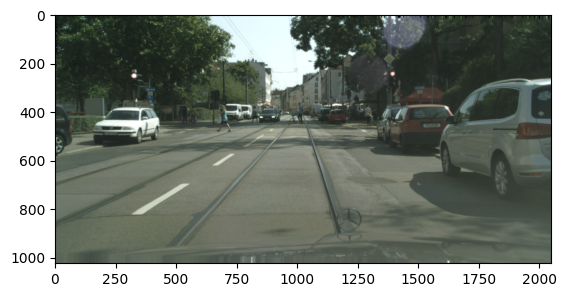

In [26]:
img_path = '/kaggle/input/dsnet-dataset/DSNet/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png'

img = cv2.imread(img_path)

image = Image.open(img_path).convert('RGB')
original_size = image.size

print(original_size)
plt.imshow(image)

In [27]:
input = transform(image).unsqueeze(0).to(device)
print(input.shape)

torch.Size([1, 3, 1024, 2048])


In [28]:
output = model_checkpoint(input)
print(f'Len of Output: {len(output)}')
print(output[0].shape)

Len of Output: 3
torch.Size([1, 19, 1024, 2048])


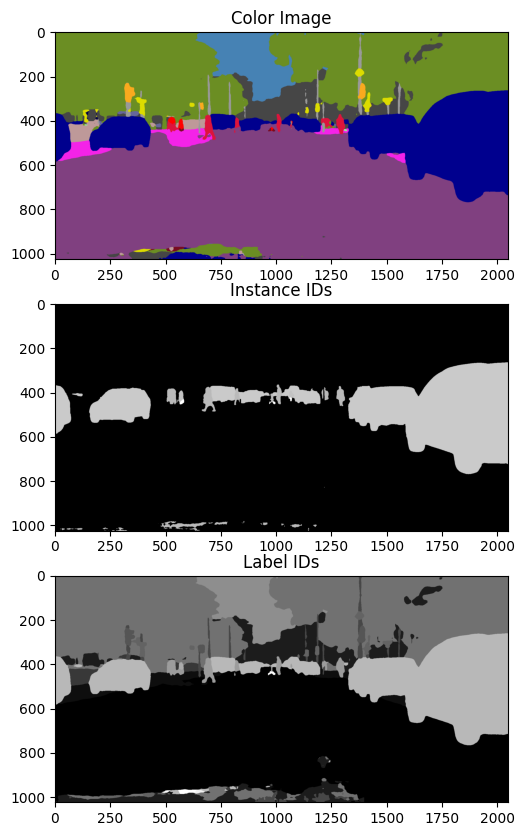

In [29]:
plt.figure(figsize=(10, 10))
original_size_image = (original_size[1], original_size[0])

for i in range(3):
    channels_tensor = output[i][0]
    output_predictions = channels_tensor.argmax(0)
    output_np = output_predictions.cpu().numpy()

    output_resized_1 = cv2.resize(output_np, (original_size_image[1], original_size_image[0]), interpolation=cv2.INTER_NEAREST)

    plt.subplot(3, 1, i + 1)

    if i == 0:
        height, width = output_resized_1.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in range(color_map.shape[0]):
            rgb_image[output_resized_1 == class_id] = color_map[class_id]
        plt.imshow(rgb_image)
        plt.title('Color Image')
    elif i == 1:
        height, width = output_resized_1.shape
        instance_image = np.zeros((height, width), dtype=np.uint8)
        for class_id in range(19):
            if class_id in instance_id:
                instance_image[output_resized_1 == class_id] = instance_color[class_id - 11]
            else:
                instance_image[output_resized_1 == class_id] = 0
        plt.imshow(instance_image, cmap='gray')
        plt.title('Instance IDs')
    else:
        plt.imshow(output_resized_1, cmap='gray')
        plt.title('Label IDs')

In [30]:
img_true_path = '/kaggle/input/dsnet-dataset/DSNet/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png'

img_true = cv2.imread(img_true_path)
img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)

img_true = np.vectorize(label_mapping.get)(img_true)

Text(0.5, 1.0, 'Prediction Image')

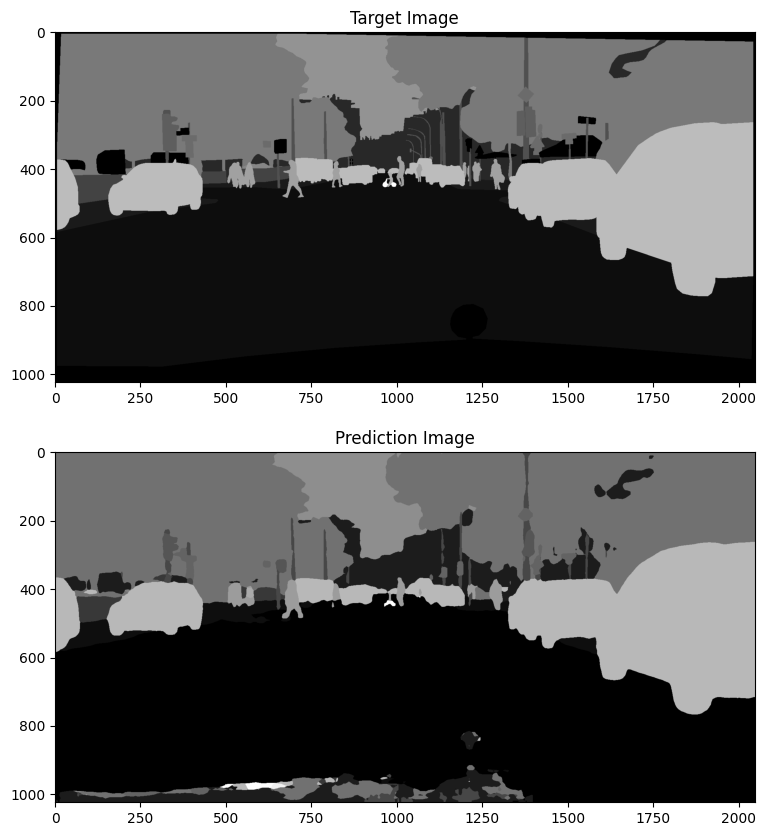

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")

plt.subplot(2, 1, 2)
plt.imshow(output_resized_1, cmap='gray')
plt.title("Prediction Image")

In [32]:
evaluate(img_true, output_resized_1, 19)

Pixel Accuracy: 0.967224245784586
Mean Pixel Accuracy: 0.6416792161691447
Intersection over Union: 0.48143143045771847
Frequency Weighted IoU: 0.7457742980703587


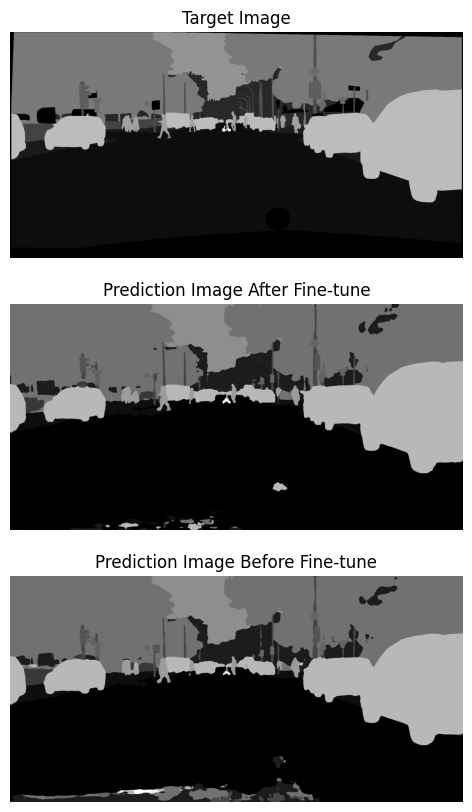

In [36]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.imshow(img_true, cmap='gray')
plt.title("Target Image")
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(output_resized, cmap='gray')
plt.title("Prediction Image After Fine-tune")
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(output_resized_1, cmap='gray')
plt.title("Prediction Image Before Fine-tune")
plt.axis('off')

plt.savefig('prediction.png', dpi=500, bbox_inches='tight')